- https://towardsdatascience.com/time-series-classification-with-deep-learning-d238f0147d6f


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
from seaborn import distplot, heatmap
from yellowbrick.features.radviz import radviz
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from dtaidistance.dtw import distance
from dtaidistance import dtw_ndim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize']=(12,8)

In [2]:
data = pd.read_csv('train_data/train_data.csv')
data

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,RUL
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,...,84.93,14.35,8.4712,NaN,NaN,NaN,NaN,NaN,NaN,339
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,...,100.00,14.88,8.9928,NaN,NaN,NaN,NaN,NaN,NaN,338
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,...,84.93,14.21,8.5107,NaN,NaN,NaN,NaN,NaN,NaN,337
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,...,100.00,10.63,6.4578,NaN,NaN,NaN,NaN,NaN,NaN,336
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,...,100.00,14.95,9.0279,NaN,NaN,NaN,NaN,NaN,NaN,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,708,159,10.0040,0.2519,100.0,489.05,605.81,1508.72,1333.13,10.52,...,100.00,28.48,16.8884,NaN,NaN,NaN,NaN,NaN,NaN,4
160355,708,160,10.0074,0.2500,100.0,489.05,605.83,1509.90,1328.53,10.52,...,100.00,28.20,16.9498,NaN,NaN,NaN,NaN,NaN,NaN,3
160356,708,161,34.9982,0.8400,100.0,449.44,556.62,1374.56,1145.17,5.48,...,100.00,14.76,8.9228,NaN,NaN,NaN,NaN,NaN,NaN,2
160357,708,162,24.9993,0.6219,60.0,462.54,537.58,1274.92,1064.82,7.05,...,84.93,14.05,8.3890,NaN,NaN,NaN,NaN,NaN,NaN,1


# Cleaning

In [9]:
class Clean :
    def __init__(self, drop_target = True) :
        self.encoder = OrdinalEncoder()
        self.to_encode = ['op_setting_' + str(i) for i in range(1,4)]
        self.drop_target = drop_target
        pass
    
    def cleaning(self, X) :
        clean_df= X.copy()
        
        if self.drop_target :
            #Drop failure steps
            clean_df = clean_df[clean_df.RUL != 0]

            #drop target column
            clean_df.drop(columns=['RUL'], inplace = True)
        
        #Drop sensors 22 to 27 with missing values
        clean_df = clean_df.drop(['sensor_' + str(i) for i in range(22,28)], axis = 1)
    
        #Settings columns correspond to categroical values, converting them to int
        clean_df[['op_setting_3', 'op_setting_1']] = clean_df[['op_setting_3', 'op_setting_1']].astype('int')
        clean_df['op_setting_2'] = (100 * clean_df['op_setting_2']).astype('int')
        
        #Add target feature 
        #clean_df['failure_in_100'] = (clean_df['RUL'] <= 100 ) *1
        
        return clean_df
    
    
    def fit_transform(self, X, y=None) :
        X_= X.copy()
        X_ = self.cleaning(X_)
        X_[self.to_encode] = self.encoder.fit_transform(X_[self.to_encode])
        
        return X_
    
    def transform(self, X, y=None) :
        X_= X.copy()
        X_ = self.cleaning(X_)
        X_[self.to_encode] = self.encoder.transform(X_[self.to_encode])
        return X_
    
    def fit(self, X, y=None) :
        self.encoder.fit(X_[self.to_encode])
        return self

In [4]:
class Scaler(StandardScaler) :
    def __init__(self) : 
        self.std = StandardScaler()
        self.to_std = ['sensor_' + str(i) for i in range(1,22)]
        
    def fit_transform(self, X, y=None) :
        X[self.to_std] = self.std.fit_transform(X[self.to_std])
        return X

    def transform(self, X, y=None) :
        X[self.to_std] = self.std.transform(X[self.to_std])
        return X
    def fit(self, X, y=None) :
        self.std.fit(X[self.to_std])
        return


# Settings

In [86]:
settings = clean[['op_setting_3', 'op_setting_1', 'op_setting_2']]
settings.value_counts()

op_setting_3  op_setting_1  op_setting_2
100           0             0               62633
              42            84              23053
              35            84              13963
60            25            62              13851
100           10            25              13842
              20            70              13802
              41            84               5800
              9             25               3478
              19            70               3411
60            24            62               3290
100           34            84               3236
dtype: int64

In [96]:
setting_configurations = settings.groupby(settings.columns.tolist(),as_index=False).size()
setting_configurations

,op_setting_3,op_setting_1,op_setting_2,size
0,60,24,62,3290
1,60,25,62,13851
2,100,0,0,62633
3,100,9,25,3478
4,100,10,25,13842
5,100,19,70,3411
6,100,20,70,13802
7,100,34,84,3236
8,100,35,84,13963
9,100,41,84,5800


# Failing cycles 

In [139]:
n_cycles = data.groupby('engine_no').time_in_cycles.max()
n_cycles.min()

128

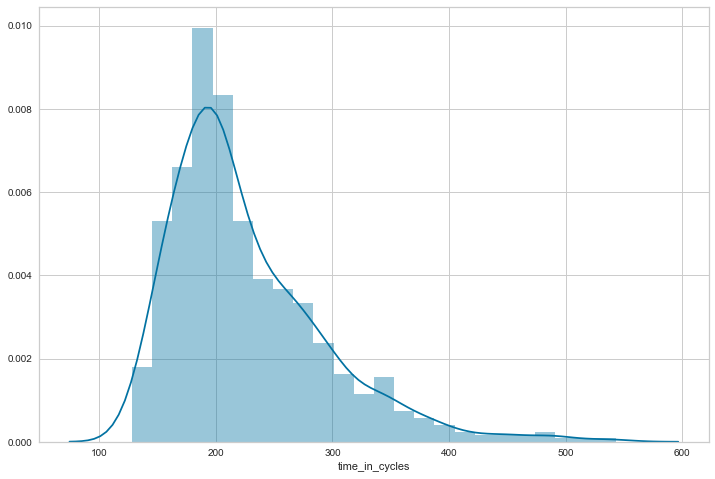

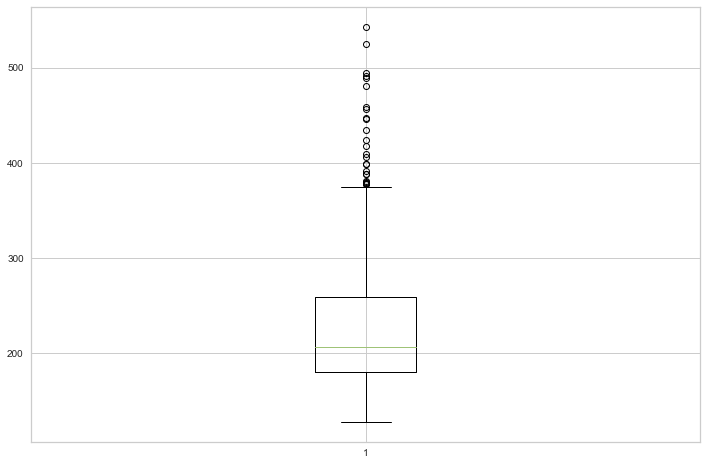

In [138]:
distplot(n_cycles)
plt.figure()
plt.boxplot(n_cycles)
plt.show()

# Settings

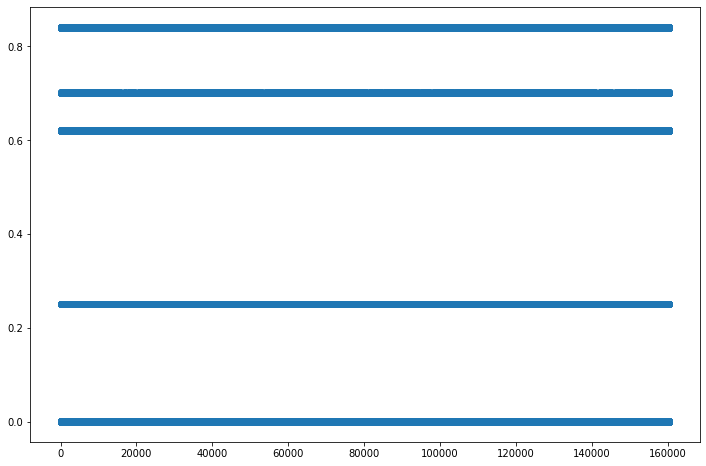

In [63]:
data.op_setting_2.plot(style = 'o')

plt.show()

# Plot parameters evolution

In [29]:
preprocessed

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_18,sensor_19,sensor_20,sensor_21,RUL,pca_1,pca_2,pca_3,pca_4,pca_5
0,0,1,6.0,2.0,0.0,-0.765965,-1.424749,-1.781391,-1.591981,-0.666973,...,-2.517348,-2.890552,-0.991560,-1.011326,339,6.430773,5.876770,-0.152907,-0.174993,0.030626
1,0,2,8.0,4.0,1.0,-1.196599,-0.986879,-0.868337,-0.969969,-1.035039,...,-0.356137,0.345955,-0.946227,-0.936972,338,5.811871,-1.555342,0.248620,0.164460,-0.156635
2,0,3,6.0,2.0,0.0,-0.765965,-1.434636,-1.701678,-1.568063,-0.666973,...,-2.517348,-2.890552,-1.003534,-1.005696,337,6.410379,5.843114,-0.175730,-0.172710,0.001842
3,0,4,10.0,4.0,1.0,-1.342554,-1.128833,-0.943649,-1.064907,-1.403104,...,-0.433323,0.345955,-1.309743,-1.298338,336,7.608029,-2.295917,-0.565977,-0.325554,0.027166
4,0,5,8.0,4.0,1.0,-1.196599,-0.992293,-0.896939,-1.007533,-1.035039,...,-0.356137,0.345955,-0.940240,-0.931968,335,5.830798,-1.541327,0.246073,0.174447,-0.163868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,708,159,2.0,1.0,1.0,0.105492,0.198901,0.352734,0.529521,0.146523,...,0.317487,0.345955,0.217022,0.188552,4,-2.681488,-0.614025,-0.818075,0.961271,-0.282509
160355,708,160,2.0,1.0,1.0,0.105492,0.199371,0.362720,0.495772,0.146523,...,0.317487,0.345955,0.193073,0.197304,3,-2.681720,-0.630791,-0.826534,0.970383,-0.290590
160356,708,161,7.0,4.0,1.0,-1.196599,-0.959100,-0.782532,-0.849499,-1.035039,...,-0.356137,0.345955,-0.956491,-0.946950,2,4.958338,-1.584295,0.381012,0.712608,-0.558889
160357,708,162,5.0,2.0,0.0,-0.765965,-1.407328,-1.625689,-1.439009,-0.666973,...,-2.517348,-2.890552,-1.017220,-1.023044,1,5.590538,5.878539,-0.001489,0.365716,-0.341914


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

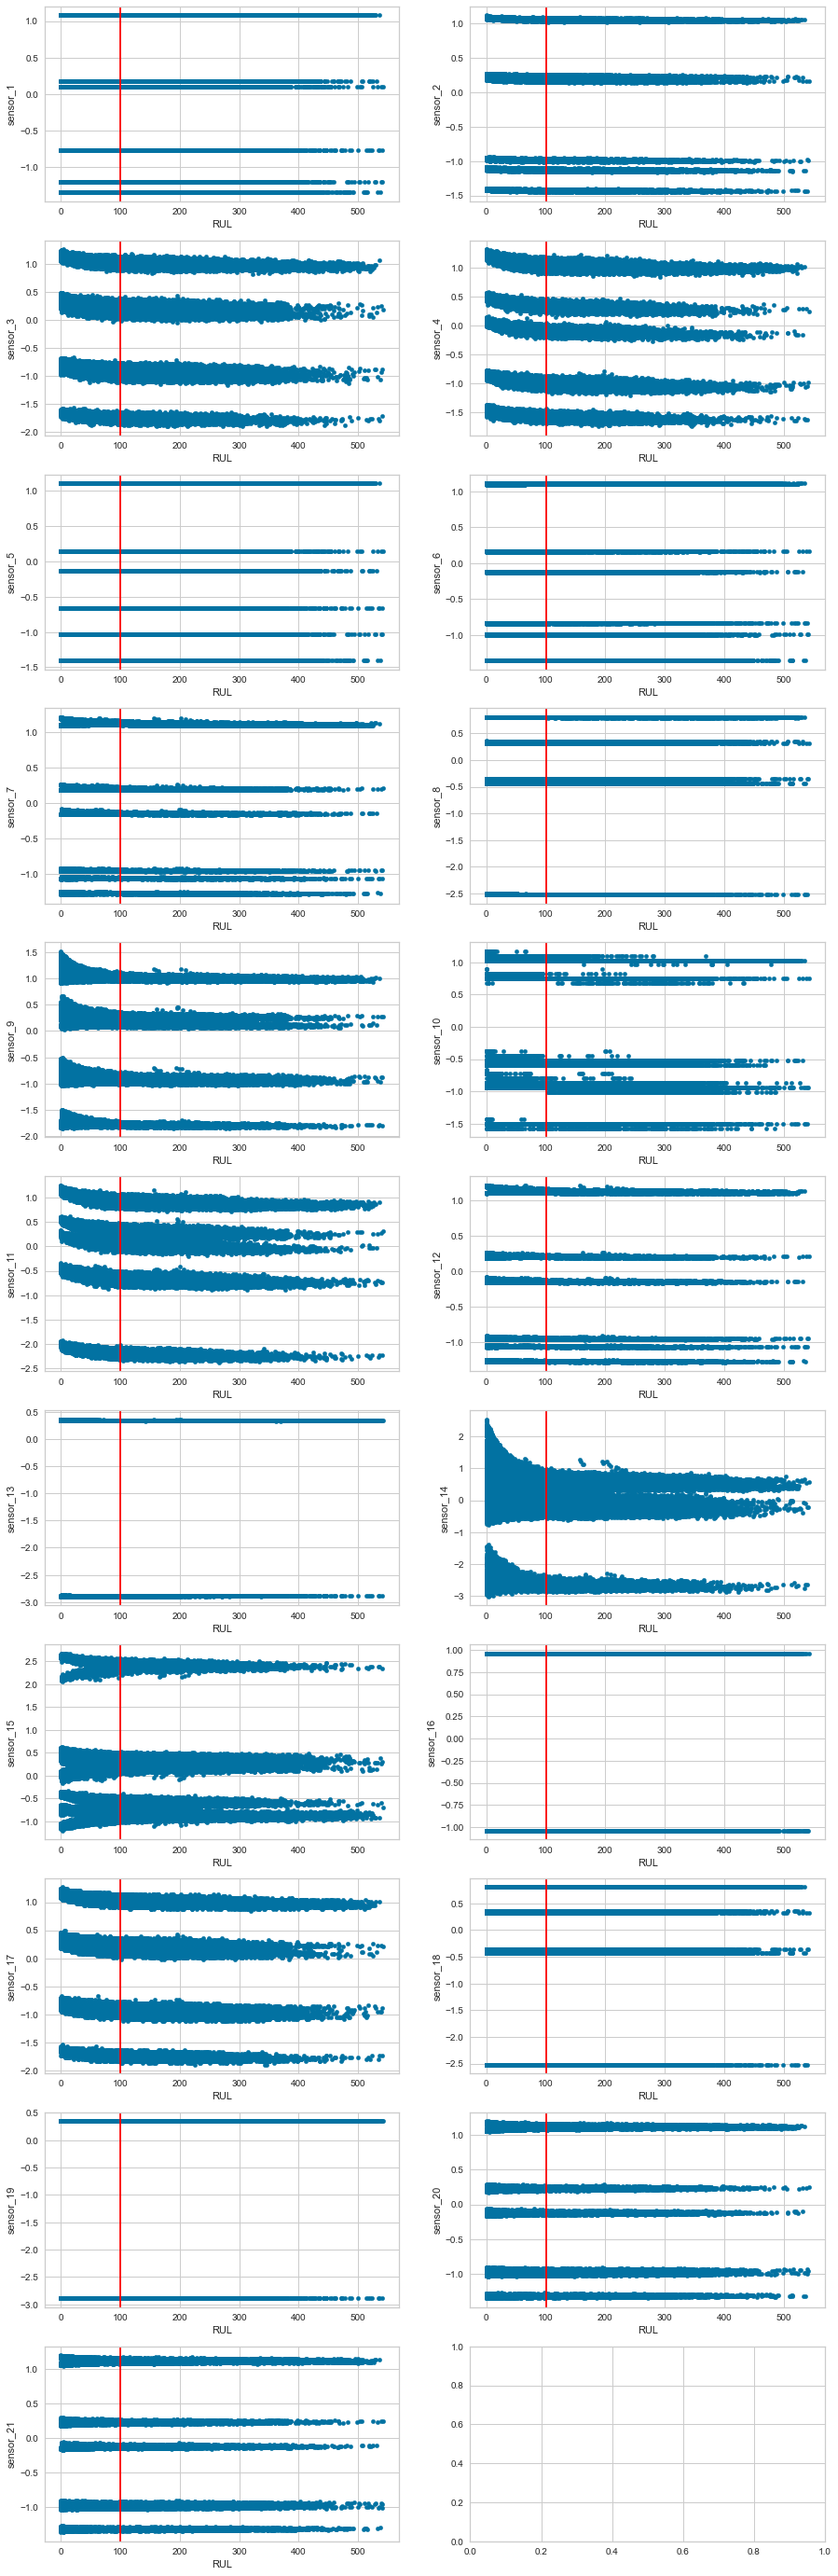

In [25]:
fig,axes = plt.subplots(11,2, figsize = (15,50))
for i in range(21) :
    ax = axes[i//2 , i%2]
    sensor = 'sensor_{}'.format(i+1)
    preprocessed.plot.scatter(x = 'RUL' , y=sensor, ax=ax)
    ax.axvline(x=100, color = 'red')
    
plt.show()

# Correlations

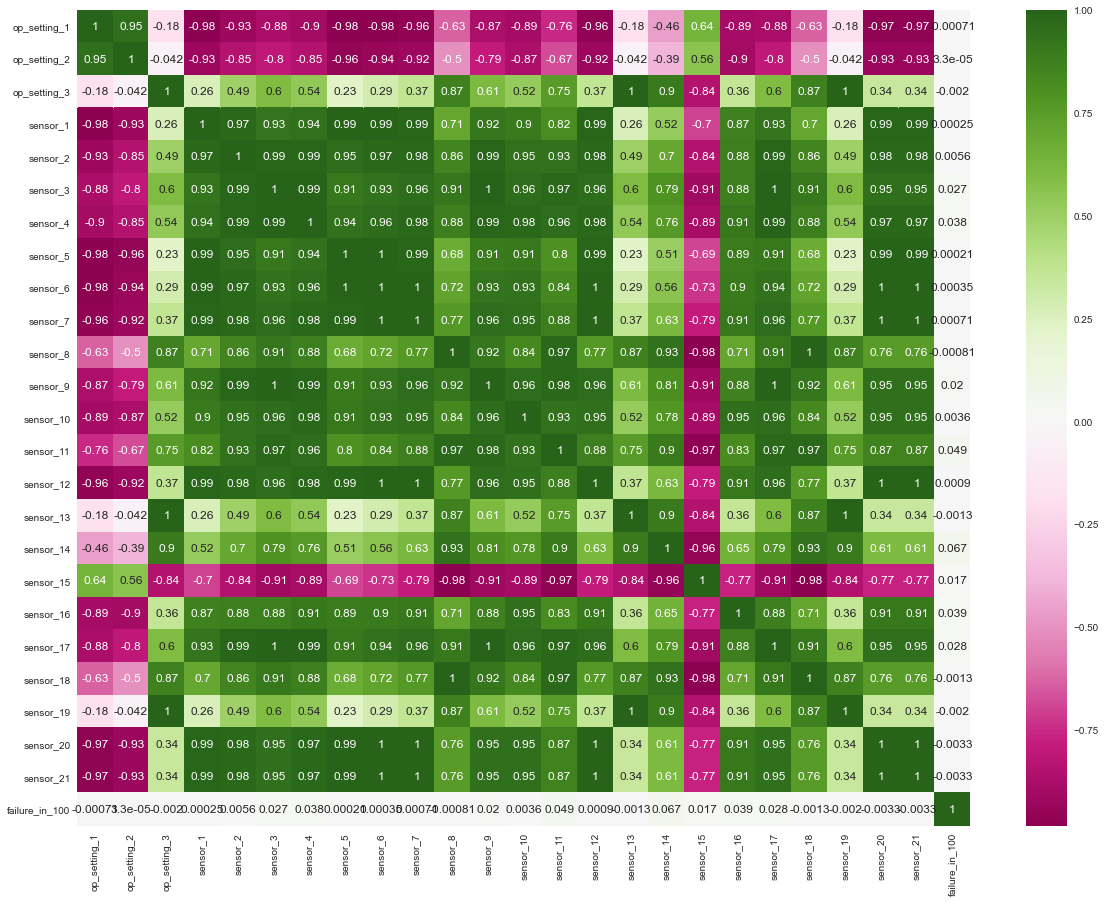

In [212]:
X = transformed
X.drop(columns=['engine_no', 'time_in_cycles', 'RUL'], inplace = True)
plt.figure(figsize = (20,15))
heatmap(X.corr(), annot=True, cmap = "PiYG")
plt.show()

# PCA

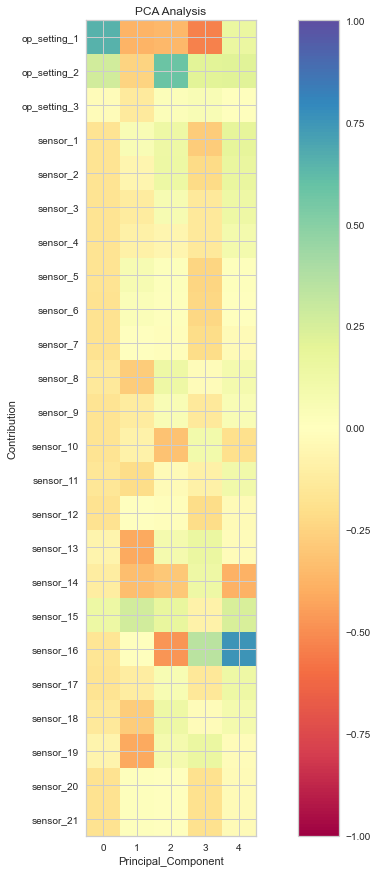

In [169]:
pca = PCA(n_components = 5)
X = preprocessed.drop(columns=['engine_no', 'time_in_cycles', 'RUL', 'failure_in_100'])
pca.fit(X)
fig,ax=plt.subplots(figsize = (15,15))
plt.imshow(pca.components_.T, cmap = 'Spectral', vmin=-1, vmax=1)
plt.yticks(range(len(X.columns)), X.columns)
#plt.xticks(range(30), range(1,30))
plt.xlabel('Principal_Component')
plt.ylabel('Contribution')
plt.colorbar()
plt.title('PCA Analysis')
plt.show()

In [13]:
pca.explained_variance_ratio_

array([0.85458299, 0.12773469, 0.00973844, 0.00492509, 0.00135469])

In [36]:
class PCA_Reduction() :
    def __init__(self, n_components = 5, drop = True) :
        self.n_components = n_components
        self.pca = PCA(n_components = self.n_components)
        self.to_reduce = ['op_setting_' + str(i) for i in range(1,4)] + ['sensor_' + str(i) for i in range(1,22)]
        self.drop = drop
        pass
    
    def fit_transform(self, X, y=None) :
        X_ = X.copy()
        comp_features = ['pca_' + str(i) for i in range(1,self.n_components + 1)]
        X_[comp_features] = self.pca.fit_transform(X_[self.to_reduce])
        if self.drop : 
            X_.drop(columns = self.to_reduce, inplace = True)
        return X_
    
    def transform(self, X, y=None) :
        X_ = X.copy()
        comp_features = ['pca_' + str(i) for i in range(1,self.n_components + 1)]
        X_[comp_features] = self.pca.transform(X_[self.to_reduce])
        X_.drop(columns = self.to_reduce, inplace = True)
        return X_
    def fit(self, X, y=None) :
        self.pca.fit(X_[self.to_reduce])
        return self

pca = PCA_Reduction()
pca.fit_transform(preprocessed)

,engine_no,time_in_cycles,RUL,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10
0,0,1,339,6.430773,5.876770,-0.152907,-0.174993,0.030626,-0.026989,0.014228,-0.036132,-0.015317,0.022526
1,0,2,338,5.811871,-1.555342,0.248620,0.164460,-0.156635,-0.236198,0.263537,0.045038,0.026953,-0.020135
2,0,3,337,6.410379,5.843114,-0.175730,-0.172710,0.001842,0.072168,0.048140,-0.044774,-0.043590,-0.060991
3,0,4,336,7.608029,-2.295917,-0.565977,-0.325554,0.027166,0.034962,-0.023392,-0.100664,-0.028595,-0.049382
4,0,5,335,5.830798,-1.541327,0.246073,0.174447,-0.163868,-0.171253,0.288614,0.066298,-0.060268,-0.006838
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,708,159,4,-2.681488,-0.614025,-0.818075,0.961271,-0.282509,0.866576,0.114535,0.016413,-0.106686,0.023318
160355,708,160,3,-2.681720,-0.630791,-0.826534,0.970383,-0.290590,0.880395,0.110578,0.030617,-0.090224,0.025348
160356,708,161,2,4.958338,-1.584295,0.381012,0.712608,-0.558889,0.725557,0.480659,0.181502,-0.106648,0.038494
160357,708,162,1,5.590538,5.878539,-0.001489,0.365716,-0.341914,0.914008,0.202195,0.121869,-0.167973,0.003610


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

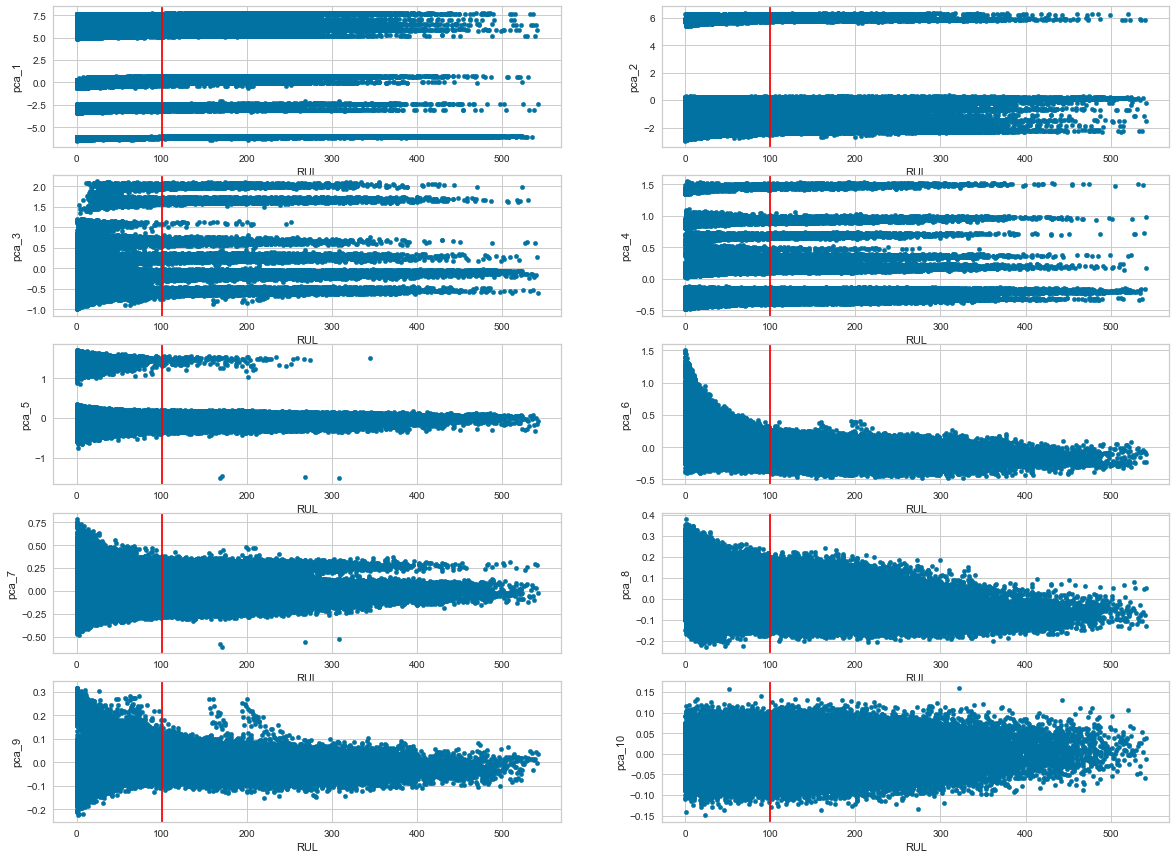

In [38]:
n_components = 10
fig,axes = plt.subplots(5,2, figsize = (20,15))
for i in range(n_components) :
    ax = axes[i//2 , i%2]
    component = 'pca_{}'.format(i+1)
    preprocessed.plot.scatter(x = 'RUL' , y=component, ax=ax)
    ax.axvline(x=100, color = 'red')
    
plt.show()

# Time series extraction

In [ ]:
class TS_Extract() :
    """
    Transforms a dataframe into a numpy array of dimension (n_engines, n_steps, n_features) containing 
    the last n = n_steps time cycles for each engine.
    """
    def __init__(self, length = 50, stride = 20) :

        self.length = length
        self.stride = stride
        pass
    
    
    def extract_ts (self, X_arr) : 
        n_cycles = X_arr.shape[0]
        L = [ X_arr[i: i + self.length] for i in range(0, n_cycles - self.length+1 , self.stride)]
        return L

    def fit(self, X, y=None) :
        return self
    
    def fit_transform(self, X, y=None) :
        X_ = X.copy()

        X_.set_index(['engine_no'], inplace = True)
        
        L = []
        
        for engine in range(0, X_.index.get_level_values(0).max() +1) :
           
            engine_cycles = X_.loc[engine].to_numpy()
            
            L += self.extract_ts(engine_cycles)
        #L = np.array([X_.loc[i].iloc[-self.n_steps:].to_numpy() for i in range(0, X_.index.get_level_values(0).max() +1)])
        
        return np.array(L)
    
    def transform(self, X,y=None) :
        return self.fit_transform(X,y)


# Pipeline

In [37]:
preprocessing_pipe = Pipeline(steps = [
    ('cleaning', Clean(drop_target=False)),
    ('scaling', Scaler()),
    ('reduction', PCA_Reduction(n_components = 10, drop = False))
])

preprocessed = preprocessing_pipe.fit_transform(data)

In [8]:
X_pipe = Pipeline(steps = [
    ('cleaning', Clean()),
    ('scaling', Scaler()),
    ('reduction', PCA_Reduction(n_components = 5)),
    ('time_series_extraction', TS_Extract(length = 100, stride = 500))
])

transformed = X_pipe.fit_transform(data)
transformed.shape

(709, 100, 6)

In [9]:
target_pipe = Pipeline(steps = [
    ('target_extraction', Build_Target(length = 100, stride = 500))
])

target = target_pipe.fit_transform(data)
target.shape

(709, 1)

# Extract ts

In [10]:
length = 50
stride = 50
n_components = 5

X_pipe = Pipeline(steps = [
    ('cleaning', Clean()),
    ('scaling', Scaler()),
    ('reduction', PCA_Reduction(n_components = n_components)),
    ('time_series_extraction', TS_Extract(length, stride))
])

y_pipe = Pipeline(steps = [
    ('target_extraction', Build_Target(length, stride))
])

y = y_pipe.fit_transform(data)
X = X_pipe.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [50]:
start_time = time.time()

dtw_ndim.distance_matrix(X_train, ndim = X.shape[-1], max_dist = 1, use_pruning = False, show_progress = True)

#dtw_ndim.distance(X_train[0], X_train[2], max_dist = 1, use_pruning = True)
print("--- %s seconds ---" % (time.time() - start_time))

  3%|█▏                                    | 59/1900 [10:45<5:35:47, 10.94s/it]


KeyboardInterrupt: 

In [48]:
X_train[i] 

array([[ 5.10000000e+01,  5.77100317e+00,  6.21984079e+00,
         2.00132390e-01,  3.47648751e-01, -1.11142187e-01],
       [ 5.20000000e+01, -6.11679537e+00,  4.78384989e-02,
        -1.10698544e-01, -2.46511699e-01,  1.96058066e-02],
       [ 5.30000000e+01, -4.01045713e-02, -3.63702507e-01,
         2.01993090e+00,  3.12372278e-01, -1.84822758e-01],
       [ 5.40000000e+01,  5.83659542e+00, -1.51244433e+00,
         2.77273160e-01,  1.44565230e-01, -9.78440356e-02],
       [ 5.50000000e+01,  7.60110887e+00, -2.29163732e+00,
        -5.41553684e-01, -3.60052633e-01,  8.57570187e-02],
       [ 5.60000000e+01,  7.59817069e+00, -2.28747238e+00,
        -5.44316185e-01, -3.62968825e-01,  9.13210229e-02],
       [ 5.70000000e+01,  6.43247553e+00,  5.85370937e+00,
        -1.59469995e-01, -1.72635195e-01,  2.31174568e-02],
       [ 5.80000000e+01,  7.60047206e+00, -2.28912925e+00,
        -5.42019404e-01, -3.62741666e-01,  9.15662799e-02],
       [ 5.90000000e+01,  6.22524886e-01, -7.225

In [36]:
n = X_train.shape[0]
distance_matrix = np.zeros((n,n))

for i in range(n) :
    for j in range(i,n) :
        distance_matrix[i,j] = abs() 
        #dtw_ndim.distance(X_train[i], X_train[j], use_pruning = True)
        if j%1000 == 0:
            print('progress = ',100*(n*i+j)/(n*n), ' %' )


progress =  0.0  %


KeyboardInterrupt: 

In [168]:
distance_matrix = dtw_ndim.distance_matrix( X, ndim = X.shape[-1] , show_progress = True)

  0%|                                    | 4/2837 [11:18<133:27:23, 169.59s/it]


KeyboardInterrupt: 

In [143]:
g = np.array([[[1,2],[7,2],[1,8]],[[1,2],[1,2],[1,2]],[[1,2],[1,2],[1,2]]])
dtw_ndim.distance(g,g)

0.0

In [160]:
dtw_ndim.distance_matrix(g, ndim = 2)

array([[0.        , 8.48528137, 8.48528137],
       [8.48528137, 0.        , 0.        ],
       [8.48528137, 0.        , 0.        ]])

In [153]:
distance = np.zeros((g.shape[0],g.shape[0]))
for i in range(g.shape[0]) :
    for j in range(g.shape[0]) :
        distance[i,j] = dtw_ndim.distance(g[i], g[j])
distance

array([[0.        , 8.48528137, 8.48528137],
       [8.48528137, 0.        , 0.        ],
       [8.48528137, 0.        , 0.        ]])

# KNN

In [38]:
knn = KNeighborsClassifier(n_neighbors=1, metric = 'minkowski')

In [39]:
knn.fit(X,y)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
from seaborn import distplot, heatmap
from yellowbrick.features.radviz import radviz
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from dtaidistance.dtw import distance
from dtaidistance import dtw_ndim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize']=(12,8)